Imports and ignore future warnings

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime as dt
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from utils.calculations_simply import *
from utils.df_operations import *
from utils.yahoo_queries import *

Explore vol momentum as a ranking methodology

##### Simple pull of SPX names from wiki, slight correction in names with '-' instead of '.'

In [4]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [5]:
stock_data = pd.read_html(str(table))[0]
names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

##### Download prices and returns for our universe of names for 1 business month

In [6]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [7]:
px = yf.download(name_query, start=start_date)
rets = px.pct_change(1)

[*********************100%***********************]  503 of 503 completed


##### Convert to ticker format such that we can call in threaded format

In [8]:
tickers = yf.Tickers(name_query)

In [9]:
thread_count = 25
name_count = 200

thread_loop = []

with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(exp_retrieve, name, thread_loop, tickers) for name in names[:name_count]]
    
with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(option_retrieve, tick, name, exp, px, rets) for tick, name, exp in thread_loop]
    
opt_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)

##### Calculate vol and delta values and insert into frame.

1. Data is sparse in some cases, be it during some time of day or just a poor population on the yahoo side
2. We will address this in future by finding best time to query and method to incrementally populate with best data

In [10]:
test_chain = get_delta_values(opt_chain)
test_chain = test_chain[test_chain['callput'] == 'call']

/Users/benjaminbowring/Desktop/Coding/OptionSite/utils/calculations_simply.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s / k) + (R + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))


In [26]:
test_chain[test_chain['ticker'] == 'AAPL'].iloc[50]

contractSymbol             AAPL230217C00055000
lastTradeDate        2022-08-11 13:40:54+00:00
strike                                    55.0
lastPrice                                115.6
bid                                      114.2
ask                                     114.65
change                                     5.4
percentChange                          4.90018
volume                                     2.0
openInterest                             442.0
impliedVolatility                     7.960938
inTheMoney                                True
contractSize                           REGULAR
currency                                   USD
callput                                   call
expiry                              2023-02-17
ticker                                    AAPL
stock_px                            130.729996
stock_ret                             0.004456
k_norm                                0.420714
1d_delta                             12.117375
t_exp        

In [11]:
rebase_index = np.arange(0.8,1.21,0.01)

##### Out of interest seeing the top 10 liquid names for the last trading day

In [12]:
pd.DataFrame(test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:10])

,volume
ticker,
AMZN,398036.0
GOOGL,96032.0
GOOG,69892.0
BMY,39862.0
AAPL,39483.0
ABBV,31087.0
DIS,26066.0
T,24139.0
BAC,23833.0


In [13]:
ticks = [name for name in test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:10].index]
d_curve = test_chain[(test_chain['ticker'].isin(ticks)) & (test_chain['expiry'] == '2023-01-20') & (test_chain['callput'] == 'call')]

##### Interpolate live options onto fractional strike prices so we can get a full surface

* In some cases impossible to avoid ugly surfaces due to poor population, as data is non-historic this is unavoidable and we will find ways to incrementally improve with multiple queries

In [14]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta_calc), index = rebase_index)

    curve_df[tick] = interp_curve

##### Curves look shocking in some cases due to low liquidity

<AxesSubplot: >

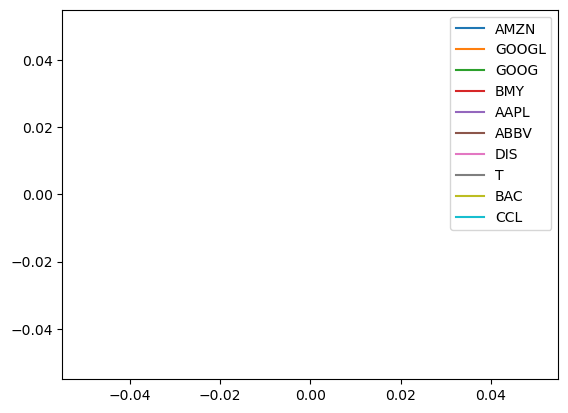

In [15]:
curve_df.plot()